Recently, a [surveillance video](https://twitter.com/TeamTrump/status/1334569329334083586) showing election officials processing ballots pulled from suitcases stashed under tables in State Farm Arena, GA has gone viral.  Soon after, [an analysis](https://electionwiz.com/2020/12/04/biden-wins-98-percent-of-one-batch-of-23000-votes-in-georgia-during-suitcasegate/) of NY Times election data surfaced, which identified an approximately 23,000--24,000 vote count update at approximately 12:18 am EST, which gives Biden a minimum of 98% of the vote.  This represents more than enough votes to change the outcome of the GA presidential election (Biden currently leads by ~12,000 votes).  Strikingly, the number of votes entered at this suspiciously high ratio agrees with estimates<sup>[1](#myfootnote1)</sup> of the number of ballots present in the aforementioned suitcases.

<a name="myfootnote1">1</a>: The estimates are based on ~2 hours of ballot counting (captured by the surveillance camera) and three machines that can process [3600 or 4900 ballots per hour](https://www.theepochtimes.com/state-farm-arena-footage-shows-poll-workers-staying-behind-pulling-out-suitcases-with-ballots_3603293.html?utm_source=newsnoe&utm_medium=email&utm_campaign=breaking-2020-12-03-3) and by estimates of the number of ballots each of the four suitcases could hold.

While the video has become the subject of much debate (with many declaring it clear evidence of voter fraud, and others denying any furtive or illegal behavior), little attention has been paid to the corresponding statistical analysis.  Let's check and see if the data used for the original analysis matches the data contained in this repository (in the [/president-senate-house/election2020_house-senate-president.csv](/president-senate-house/election2020_house-senate-president.csv) dataset).


<IPython.core.display.Javascript object>


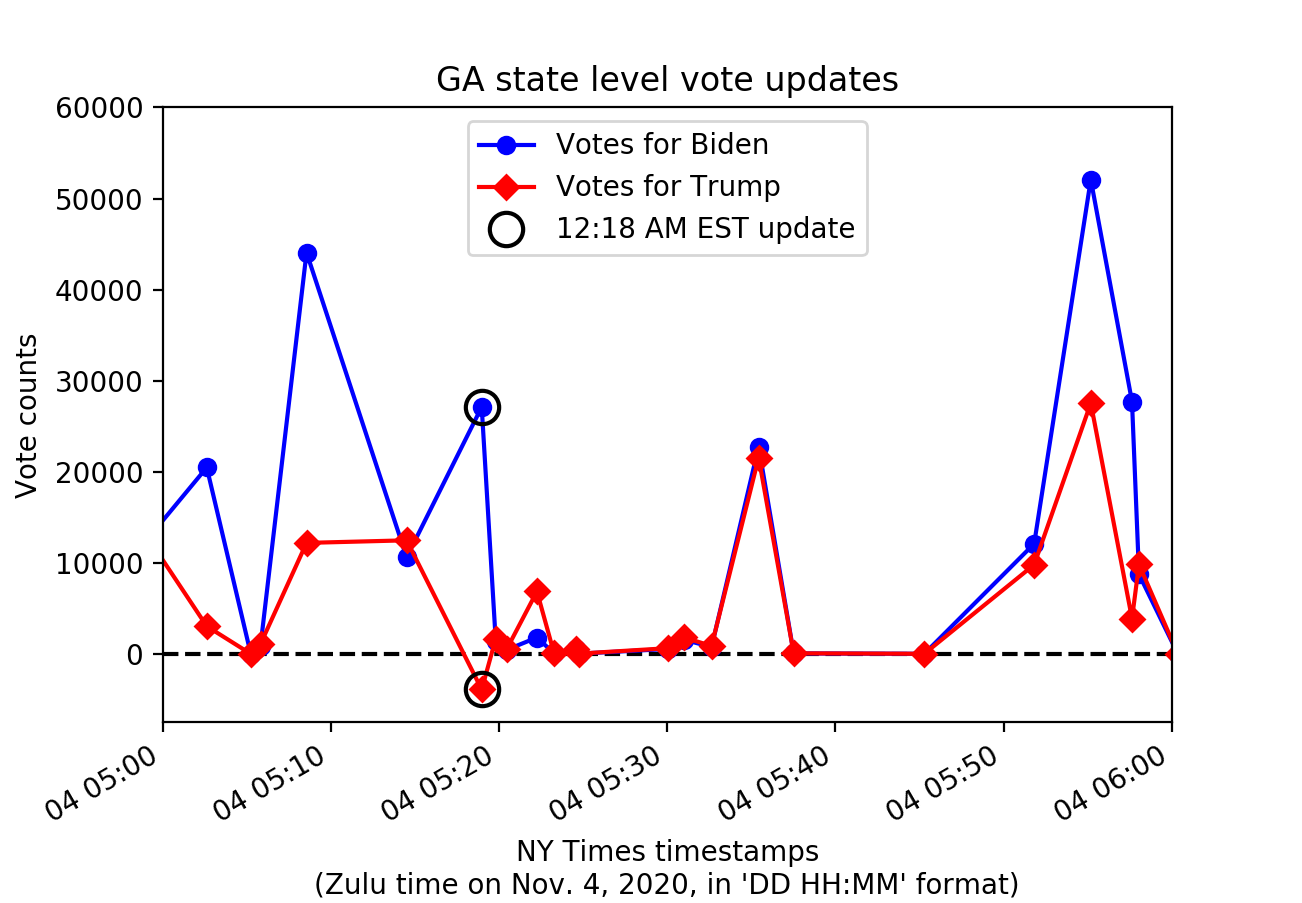

/usr/local/bin/miniconda/lib/python3.7/site-packages/ipykernel_launcher.py:42: UserWarning: The handle <matplotlib.lines.Line2D object at 0x12fbae550> has a label of '_none' which cannot be automatically added to the legend.


Text(0.5, 1.0, 'GA state level vote updates')

In [143]:
#using Python for this analysis, import the necessary modules
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib notebook


#read in the data and select rows that correspond to the election races in Georgia
state_df = pd.read_csv('general_election2020_races_timeseries.csv', index_col=False)
state_df = state_df[ state_df['state']=='GA' ]

#convert the `timestamp` column into pandas datetime objects and sort by date
state_df.sort_values(by='timestamp', inplace=True)
state_df['date'] = pd.to_datetime(state_df['timestamp'])

#convert vote fractions into vote counts.  This gives cumulative vote count updates.
state_df['votes_dem'] = state_df['votes2020'] * state_df['vf_dem']
state_df['votes_rep'] = state_df['votes2020'] * state_df['vf_rep']
state_df['votes_extra'] = state_df['votes2020'] * state_df['vf_extra']

#Get the number of votes added at each timestamp by differencing
diff_keys = ['votes2020', 'votes_dem', 'votes_rep', 'votes_extra']
state_df[diff_keys] = state_df.groupby('race_id').agg( dict(zip(diff_keys,                                                       ['diff']*len(diff_keys))) )

#select the subset of state_df that pertains to the presidential race
#...we'll use some of the other data later
state_p_df = state_df[ state_df['race_id']=='G-P' ]


#plot a slice of the timeseries between 12 am and 1 am 11/04/2020.
fig, ax = plt.subplots(1, 1)
#add a dashed line at zero votes to aid the eye
ax.axhline(0, color='k', linestyle='--')
state_p_df.plot('date', 'votes_dem', marker='o', color='b', ax=ax)
state_p_df.plot('date', 'votes_rep', marker='D', color='r', ax=ax)
#plots black circles around the 12:18 AM points to highlight that update
state_p_df[state_p_df['votes_rep'] < 0].plot('date', ['votes_dem', 'votes_rep'], 
                                             linestyle='none', marker='o', color='k', 
                                             ms=12, mfc='none', mew='1.5', ax=ax)
#format the plot
ax.set_xlim([pd.Timestamp('2020-11-04T05Z'), pd.Timestamp('2020-11-04T06Z')])
ax.set_ylim([-7500, 60000])
ax.legend(['_none', 'Votes for Biden', 'Votes for Trump', '12:18 AM EST update'], loc='upper center')
ax.set_xlabel("NY Times timestamps\n(Zulu time on Nov. 4, 2020, in 'DD HH:MM' format)")
ax.set_ylabel('Vote counts')
ax.set_title('GA state level vote updates')



The plot above showcases the NY Times data used isolate the >98% pro-Biden batch of ballots.  The strangest feature of this plot is that Trump appears to have received negative votes at 12:18 AM, which is the update in question.  While we have seen various examples of negative votes elsewhere (e.g., the viral Antrim County glitch, and the [Fairfax County, VA analysis](/county-level-president/) in this repository), they are highly irregular and each instance demands an explanation (because vote counts should only ever increase).  

The vote counts in this dataset, however, are computed from vote fractions for each candidate that have been rounded (presumably by the NY Times) to the third decimal place.  In the case of the 12:18 AM vote update, accounting for all possible vote fractions that might have rounded to the same third decimal value recorded by the NY Times reveals a narrow range where Trump's vote count would be positive, but less than 132 votes (see the original analysis linked to above).  While this solves the problem of negative votes, it means that Trump's share of the votes is now implausibly small compared to Biden's, with a minimum of 98% of the vote update going to Biden.  

This is where the analysis based on NY Times state-level presidential timeseries data ends.  The NY Times also compiled county-level, however, and, by scraping archived copies of their dataset, one can put together a timeseries of the GA presidential race for each county.  In fact, that is what I have done in the [county-level-president/](/county-level-president/) folder of this repository.  Using that dataset, we can now try to track down the county or counties that contributed to this anomalous vote count update.

<IPython.core.display.Javascript object>


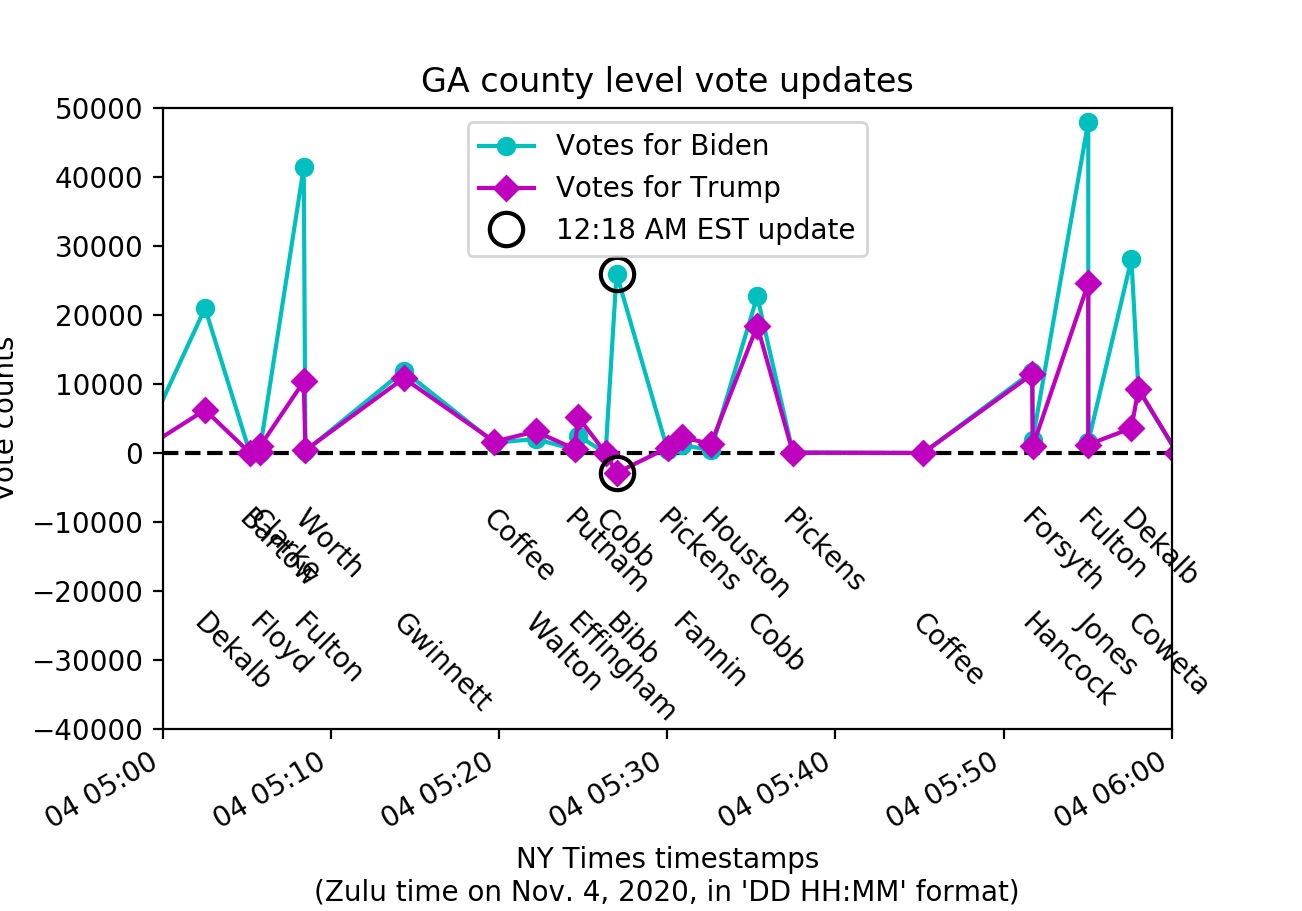

/usr/local/bin/miniconda/lib/python3.7/site-packages/ipykernel_launcher.py:33: UserWarning: The handle <matplotlib.lines.Line2D object at 0x1375f86d0> has a label of '_none' which cannot be automatically added to the legend.


In [175]:
#read in the data and keep only rows pertaining to Georgia
cnty_df = pd.read_csv('county_presidential.csv', index_col=0)
cnty_df = cnty_df[(cnty_df['state'] == 'GA')]

#sort by the time each batch was updated and create a pandas datetime colum
cnty_df.sort_values(by='last_updated', inplace=True)
cnty_df['date'] = pd.to_datetime(cnty_df['last_updated'])

#the vote updates are cumulative, so get vote counts for individual vote updates
#by differencing the columns...apply this function within groups of counties
diff_keys = ['votes2020', 'votes_dem', 'votes_rep', 'votes_jorgensen']
cnty_df[diff_keys] = cnty_df.groupby('county').agg( dict(zip(diff_keys, ['diff']*len(diff_keys))) )

#for an apples-to-apples comparison with the state-level data, compute rounded vote fractions
cnty_df['votes'] = cnty_df['votes2020'].cumsum()
cnty_df['vf_dem'] = (cnty_df['votes_dem'].cumsum() / cnty_df['votes']).round(3)
cnty_df['vf_rep'] = (cnty_df['votes_rep'].cumsum() / cnty_df['votes']).round(3)

#ignore NaN rows and zero vote updates
cnty_df = cnty_df[(cnty_df['votes2020'] != 0) & np.isfinite(cnty_df['votes2020'])]

#plot the data in a figure that is similar to the previous one
fig, ax = plt.subplots(1, 1)
ax.axhline(0, color='k', linestyle='--')
cnty_df.plot('date', 'votes_dem', marker='o', color='c', ax=ax)
cnty_df.plot('date', 'votes_rep', marker='D', color='m', ax=ax)
cnty_df[cnty_df['votes_rep'] < 0].plot('date', ['votes_dem', 'votes_rep'], linestyle='none', 
                                       marker='o', color='k', ms=12, mfc='none', mew='1.5', ax=ax)
before = pd.Timestamp('2020-11-04T05Z')
after = pd.Timestamp('2020-11-04T06Z')
ax.set_xlim([before, after])
ax.set_ylim([-40000, 50000])
ax.legend(['_none', 'Votes for Biden', 'Votes for Trump', '12:18 AM EST update'], loc='upper center')
ax.set_xlabel("NY Times timestamps\n(Zulu time on Nov. 4, 2020, in 'DD HH:MM' format)")
ax.set_ylabel('Vote counts')
ax.set_title('GA county level vote updates')

#add county labels to the plot
trunc_cnty_df = cnty_df.set_index('date').truncate(before=before, after=after)
for i, (index, county) in enumerate(trunc_cnty_df['county'].items()):
    county_label = county[0].upper() + county[1:]
    text_x = index - pd.Timedelta(1,'m')   #helps align the county labels with the corresponding points
    text_y = -7500 - 15000 * ((i+1)%2)
    ax.text(text_x, text_y, county_label, rotation=-45, va='top', ha='left')



Here we see that Bibb County, which surrounds the city of Macon, GA and voted for Obama and Hillary by 20% margins in 2012 and 2016, is responsible for the previously identified anomalous update.  Fulton County, where the processing of suitcases of ballots was surveilled, updates shortly before 12:10 AM (EST) (and again at 12:55 AM), but not at the Biden:Trump ratio needed to explain the 12:18 AM update in the state-level data.  All the county updates shown here align neatly (along the time axis) with similar spikes in the state-level data (i.e., similar in terms of their total number of votes and their Biden:Trump ratio).  The only inconsistency is the Bibb County update, which appears to lag behind the state-level update by 6-7 minutes.  Not knowing how the vote reporting actually works, I can only speculate as to whether this is a benign reporting issue or an example of electronic vote manipulation.  As I show below, however, the state and county-level datasets match perfectly in this 1 hour snapshot with the sole exception being the Bibb County update.

Unlike the state-level dataset, the data plotted in the latest figure represent precise integer vote counts, not rounded fractions of the total number of votes.  With this clarity, we are now forced to accept that (what I will now refer to as) the anomalous Bibb County update really does include a negative vote count in its update for Trump.  Perhaps, this is just another "glitch" like the viral Antrim County, MI glitch that counted some 6000 Trump votes as Biden votes.  Unlike the Antrim "glitch", this one has gone unnoticed even after a state-wide recount, and the number of votes in question here could easily swing the tight GA election back to Trump.

In case you are not convinced by my plots, perhaps MSM broadcasts from election night will convince you that this glitch is real.  The news media's election night livestreams on Youtube are long dead, but fortunately copies are available on the Internet Archive.  In particular, check out [CBS at 9:16 PM PST](https://archive.org/details/KPIX_20201104_000000_CBS_News_2020_Election_Night_--_America_Decides/start/18960/end/19020) (corresponds to 12:16 AM EST) and then watch [CNN at 9:20 PM PST](https://archive.org/details/CNNW_20201104_000000_Election_Night_in_America/start/19200/end/19260) (12:20 AM EST).  These two snapshots bookend the Bibb County update that shows up at 12:18 AM EST in the state-level dataset (the first figure).  You should see the Biden:Trump vote counts go from 1,855,860:2,181,827 to 1,881,876:2,178,942.  In other words, Biden goes up 26016 votes and Trump goes up -2885 votes (that is, he goes down).  In fact, these are exactly the numbers recorded by the NY Times for the Bibb County update!  (All updates for the whole hour are printed below.)  The negative vote "glitch" is quite real.

In [174]:
trunc_cnty_df[['county', 'votes2020', 'votes_dem', 'votes_rep']]

,county,votes2020,votes_dem,votes_rep
date,,,,
2020-11-04 05:02:31+00:00,dekalb,27855.0,21012.0,6242.0
2020-11-04 05:05:11+00:00,bartow,1.0,0.0,0.0
2020-11-04 05:05:47+00:00,floyd,203.0,26.0,175.0
2020-11-04 05:05:48+00:00,clarke,1842.0,795.0,1014.0
2020-11-04 05:08:23+00:00,fulton,52206.0,41470.0,10373.0
2020-11-04 05:08:29+00:00,worth,675.0,274.0,394.0
2020-11-04 05:14:20+00:00,gwinnett,23355.0,11918.0,10857.0
2020-11-04 05:19:43+00:00,coffee,3169.0,1493.0,1641.0
2020-11-04 05:22:10+00:00,walton,5176.0,2021.0,3129.0


Another angle we can use to shed light on the anomalous Bibb County update is a state-level comparison of how the presidential vote updates compare with the updates for down-ballot races.  Let's look in particular at the GA senatorial race between Perdue and Ossoff.

<IPython.core.display.Javascript object>


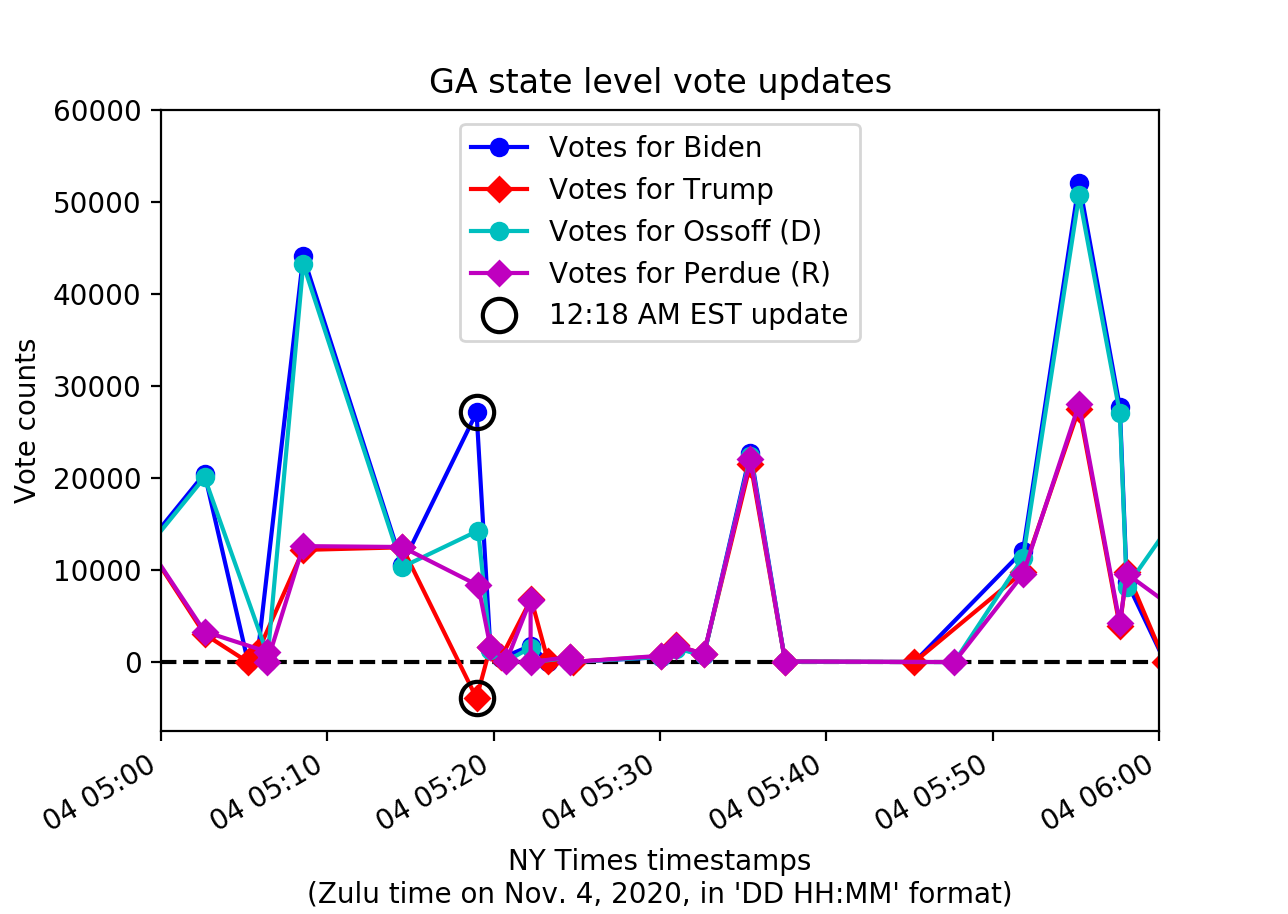

/usr/local/bin/miniconda/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: The handle <matplotlib.lines.Line2D object at 0x13cc9a190> has a label of '_none' which cannot be automatically added to the legend.


Text(0.5, 1.0, 'GA state level vote updates')

In [176]:
#select the GA senate race data
state_s_df = state_df[ state_df['race_id']=='G-S' ]

#recreate the first plot and add the senatorial timeseries
fig, ax = plt.subplots(1,1)
ax.axhline(0, color='k', linestyle='--')
state_p_df.plot('date', 'votes_dem', marker='o', color='b', ax=ax)
state_p_df.plot('date', 'votes_rep', marker='D', color='r', ax=ax)
state_s_df.plot('date', 'votes_dem', marker='o', color='c', ax=ax)
state_s_df.plot('date', 'votes_rep', marker='D', color='m', ax=ax)
state_p_df[state_p_df['votes_rep'] < 0].plot('date', ['votes_dem', 'votes_rep'], 
                                             linestyle='none', marker='o', color='k', 
                                             ms=12, mfc='none', mew='1.5', ax=ax)

#same as before except for updated legend labels
before = pd.Timestamp('2020-11-04T05Z')
after = pd.Timestamp('2020-11-04T06Z')
ax.set_xlim([before, after])
ax.set_ylim([-7500,60000])
ax.legend(['_none', 'Votes for Biden', 'Votes for Trump', 'Votes for Ossoff (D)', 
           'Votes for Perdue (R)', '12:18 AM EST update'], loc='upper center')
ax.set_xlabel("NY Times timestamps\n(Zulu time on Nov. 4, 2020, in 'DD HH:MM' format)")
ax.set_ylabel('Vote counts')
ax.set_title('GA state level vote updates')


Okay, something clearly is wrong with the anomalous Bibb County update.  The updates for the incumbent republican senator, Perdue, closely track with Trump's vote updates, while the updates for his challenger, Ossoff, likewise mirror Biden's with the massive, lone exception of the 12:18 AM (EST) update.  Instead of producing a less than zero ratio similar to Trump:Biden, the Ossoff:Perdue ratio looks quite normal (yet radically different than Trump:Biden), and indeed is consistent with what we might expect for a county that voted for Obama and Hillary by a 20% margin.  Additionally, the number of votes for Perdue + Ossoff is on par with the total number of votes for Trump + Biden (if you treat the negative Trump votes as subtracting from Biden's total).

Between the negative Trump votes and the isolated senatorial race vs. presidential race discrepancy, I believe the Bibb County election officials and the Georgia Secretary of State have a lot of explaining to do!



As an aside, I promised above that I would demonstrate the consistency between the state and county-level datasets (with the exception of the anomalous Bibb County update).  We already prepared the data for an apples-to-apples comparison of vote fractions rounded to the third decimal and the following code executes this comparison.  (We cumulatively sum votes across all the counties after sorting them by order of their last update.)

<IPython.core.display.Javascript object>


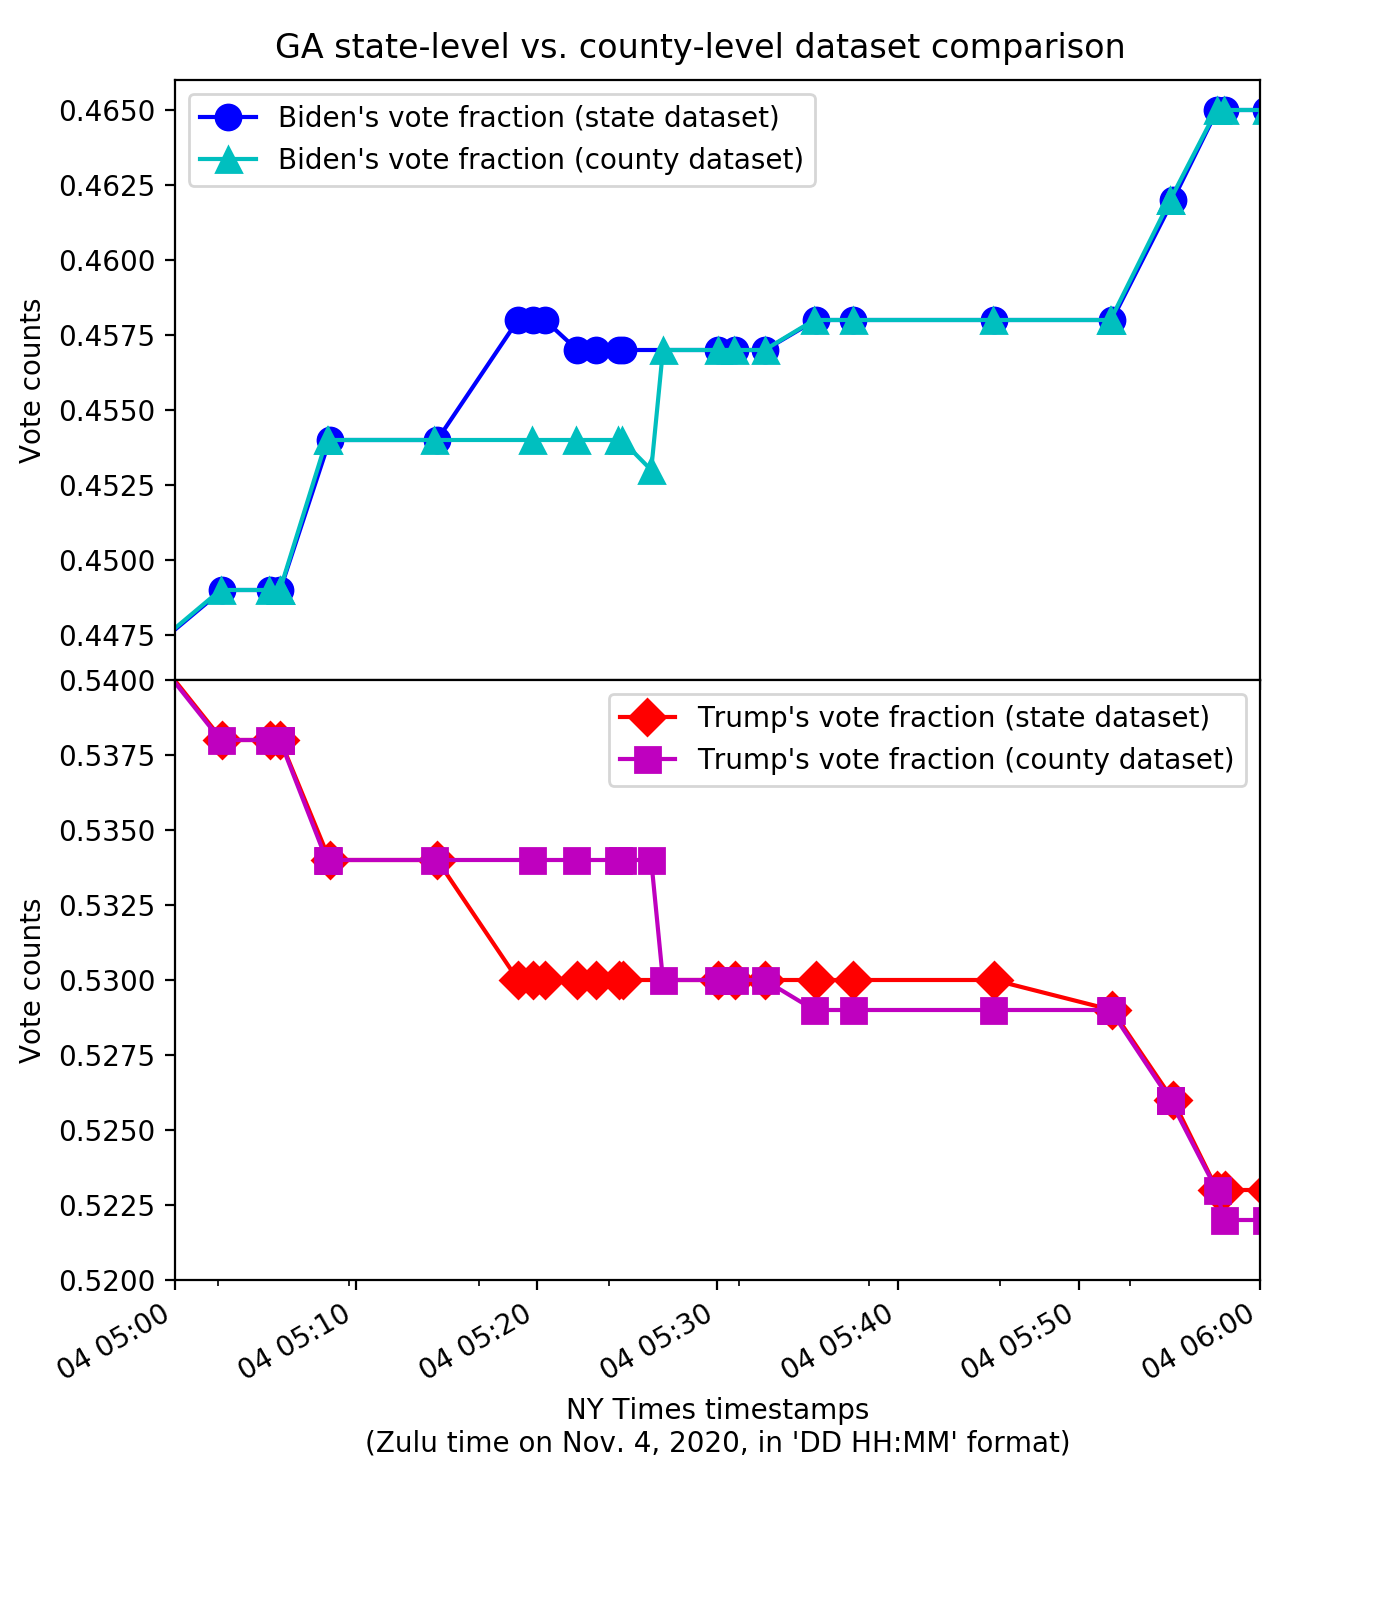

Text(0.5, 0.98, 'GA state-level vs. county-level dataset comparison')

In [170]:
#recreate the first plot and add the senatorial timeseries
fig, (ax1, ax2) = plt.subplots(2,1, sharex=True, figsize=(7, 8))
fig.subplots_adjust(hspace=0, top=0.95)
state_p_df.plot('date', 'vf_dem', marker='o', color='b', ms=9, ax=ax1)
state_p_df.plot('date', 'vf_rep', marker='D', color='r', ms=9, ax=ax2)
cnty_df.plot('date', 'vf_dem', marker='^', color='c', ms=9, ax=ax1)
cnty_df.plot('date', 'vf_rep', marker='s', color='m', ms=9, ax=ax2)

#same as before except for updated legend labels
before = pd.Timestamp('2020-11-04T05Z')
after = pd.Timestamp('2020-11-04T06Z')
ax1.set_xlim([before, after])
ax1.set_ylim([0.446,0.466])
ax2.legend(["Trump's vote fraction (state dataset)", "Trump's vote fraction (county dataset)"])
ax1.set_ylabel('Vote counts')

ax2.set_xlim([before, after])
ax2.set_ylim([0.520,0.540])
ax1.legend(["Biden's vote fraction (state dataset)", "Biden's vote fraction (county dataset)"])
ax2.set_xlabel("NY Times timestamps\n(Zulu time on Nov. 4, 2020, in 'DD HH:MM' format)")
ax2.set_ylabel('Vote counts')
fig.suptitle('GA state-level vs. county-level dataset comparison')


As you can see, the data align very closely.  I should add that this comparison returns poor results in the first 30-60 minutes of updates, which in my opinion, suggests that there is a lag in how the county level updates are filtered into the different NY Times database entries that these are datasets are drawn from (or, I suppose, it could be an issue with how Edison Research handles the data updates, since they are the source for the NY Times.)
